<a href="https://colab.research.google.com/github/Rosie-Brigham/colab-gists/blob/main/model_1c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torchvision
import os
import pandas as pd
from skimage import io
from torch.utils.data import Dataset, DataLoader # Gives easier dataset managment and creates mini batches
from PIL import Image

In [ ]:
!git clone https://github.com/monumentalconservation/training-set-circle-6.git
import os
os.getcwd()

labels = pd.read_csv(r'training-set-circle-6/image-list.csv')
test_labels = pd.read_csv(r'training-set-circle-6/testing-image-list.csv')

train_path = r'training-set-circle-6/images/'
test_path = r'training-set-circle-6/testing-images/'

fatal: destination path 'training-set-circle-6' already exists and is not an empty directory.


In [ ]:
labels.head()


,id,none,some,a lot,substantial,extensive
0,6687,1,0,0,0,0
1,6690,1,0,0,0,0
2,6725,1,0,0,0,0
3,6771,1,0,0,0,0
4,6917,1,0,0,0,0


In [ ]:
def quantify_rainfall(row):
  if row['none'] == 1:
    val = 0
  elif row['some'] == 1:
    val = 1
  elif row['a lot'] == 1:
    val = 2
  elif row['substantial'] == 1:
    val = 3
  elif row['extensive'] == 1:
    val = 4
  else:
    return 
  return val

In [ ]:
# Create nice datasets to pass into dataloader

labels['class'] = labels.apply(quantify_rainfall, axis=1)
labels = labels.drop(['none',	'some',	'a lot',	'substantial',	'extensive'], axis=1)

test_labels['class'] = test_labels.apply(quantify_rainfall, axis=1)
test_labels = test_labels.drop(['none',	'some',	'a lot',	'substantial',	'extensive'], axis=1)


In [ ]:
labels.head()

,id,class
0,6687,0
1,6690,0
2,6725,0
3,6771,0
4,6917,0


Thirs attempt at classification - following this tutorial: https://www.youtube.com/watch?v=ZoZHd0Zm3RY&ab_channel=AladdinPersson

In [ ]:
# Dataloader
class DampDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, str(self.annotations.iloc[index, 0]) + '.jpg')
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        if self.transform:
            image = self.transform(image)

        return (image, y_label)


In [ ]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transforms
damp_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((256,256)), # needed as tuple because images in dataset are different
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Hyperparameters
# in_channel = 3
# num_classes = 5
# learning_rate = 1e-3
# batch_size = 32
# num_epochs = 10

num_epochs = 15;
batch_size = 10;
learning_rate = 0.0005;
num_classes = 5

# Load Data
dataset = DampDataset(dataframe = labels, root_dir = 'training-set-circle-6/images/', transform = damp_transform)
test_dataset = DampDataset(dataframe = test_labels, root_dir = 'training-set-circle-6/testing-images/', transform = damp_transform)


In [ ]:

# Create the dataloaders
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Model
model = torchvision.models.googlenet(pretrained=True)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
# This inherits from AlexNet not CNN - not sure what the difference is, find that out
class AlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNet, self).__init__()
    
        self.features = nn.Sequential(nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),
                                      nn.Conv2d(64, 192, kernel_size=5, padding=2),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),
                                      nn.Conv2d(192, 384, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(384, 256, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),)
    
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(nn.Dropout(),
                                        nn.Linear(256 * 6 * 6, 4096),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(),
                                        nn.Linear(4096, 4096),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(4096, num_classes),)
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


In [ ]:
#instance of the Conv Net

cnn = AlexNet()
# cnn = model;

#loss function and optimizer
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);

In [ ]:
from torch.autograd import Variable


losses = [];
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # images, labels = images.cuda(), labels.cuda() - #UNCOMMENT when training with googlenet!
        images = images.float()
        # print(images.shape)
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item());
        
        if (i+1) % 10 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(dataset)//batch_size, loss.item()))

Epoch : 1/5, Iter : 10/12,  Loss: 1.6189
Epoch : 2/5, Iter : 10/12,  Loss: 1.6135
Epoch : 3/5, Iter : 10/12,  Loss: 1.6065
Epoch : 4/5, Iter : 10/12,  Loss: 1.6077
Epoch : 5/5, Iter : 10/12,  Loss: 1.6161


In [ ]:
# Now we save the model, so we can play with this after lunch
# from google.colab import drive
# drive.mount('/content/drive')

#Saving model to drive
# model_save_name = 'alexnet-15e-b10.pt'
# path = F"/content/drive/MyDrive/PhD/models/model_four/{model_save_name}" 
# torch.save(model.state_dict(), path)


NameError: ignored

In [ ]:
# LOAD PREVIOUSLY TRAINED MODEL HERE
# path = "/content/drive/MyDrive/PhD/models/model_four/[].pt" 
# model.load_state_dict(torch.load(path))
# model.eval()

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.cuda()
            model.cuda()
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

print("Checking accuracy on Training Set")
check_accuracy(train_loader, cnn)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, cnn)

Checking accuracy on Training Set
Got 25 / 125 with accuracy 20.00
Checking accuracy on Test Set
Got 5 / 25 with accuracy 20.00


In [ ]:
# test-the-model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Train Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
# torch.save(model.state_dict(), 'model.ckpt')

Train Accuracy of the model: 20.0 %


From here, these snippets are taken from this colab: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/17a7c7cb80916fcdf921097825a0f562/cifar10_tutorial.ipynb#scrollTo=TzrMwxulq03d

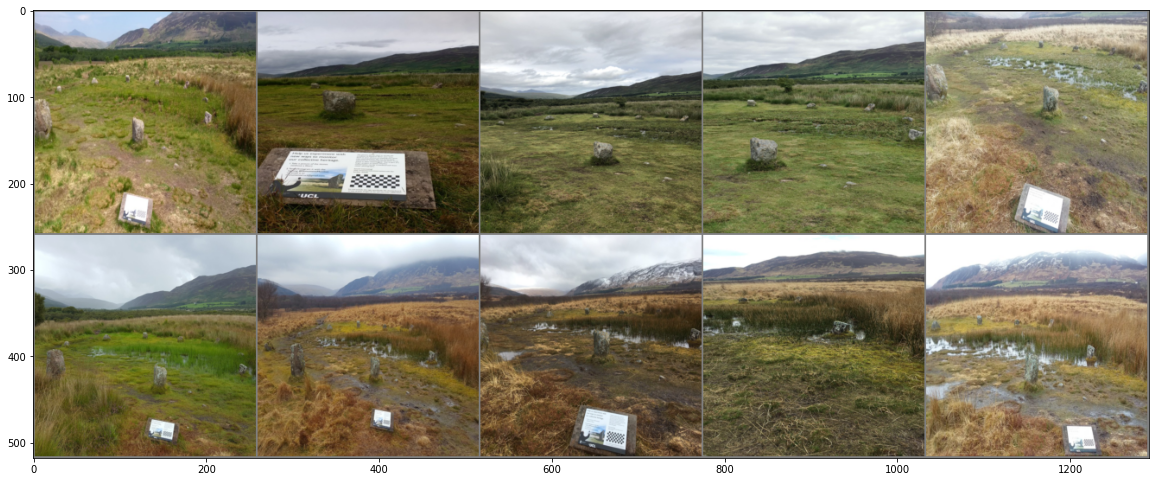

GroundTruth:   none  none  some  some substantial substantial extensive extensive substantial extensive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# see if this works...

classes = ('none', 'some', 'a lot', 'substantial', 'extensive')

dataiter = iter(test_loader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = [20,20])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# print images
imshow(torchvision.utils.make_grid(images, nrow=5))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [ ]:
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(5):
    # print(class_total[i])
    print('Accuracy of %5s : %2d %%' % (classes[i], float(100) * class_correct[i] / class_total[i]))

Accuracy of  none :  0 %
Accuracy of  some : 100 %
Accuracy of a lot :  0 %
Accuracy of substantial :  0 %
Accuracy of extensive :  0 %
